# Predict Customer Churn

Setting up the environment...

In [95]:
!pip install -r requirements_py3.6.txt

In [96]:
!pip check

tensorflow 1.3.0 requires tensorflow-tensorboard, which is not installed.
seaborn 0.11.2 has requirement matplotlib>=2.2, but you have matplotlib 2.1.0.
scikit-image 0.14.2 has requirement dask[array]>=1.0.0, but you have dask 0.16.1.
moviepy 0.2.3.2 has requirement tqdm==4.11.2, but you have tqdm 4.64.0.
jupyterlab-server 1.0.0 has requirement jsonschema>=3.0.1, but you have jsonschema 2.6.0.
ipywidgets 7.0.5 has requirement widgetsnbextension~=3.0.0, but you have widgetsnbextension 3.1.0.


## Importing libraries and configurations

In [97]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve, classification_report

In [98]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

## Reading data

In [99]:
df = pd.read_csv(r"./data/bank_data.csv", index_col = 0)
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## EDA

In [100]:
print(f'Shape of data: {df.shape}')
print(f'Columns of the data:')
df.columns.values

Shape of data: (10127, 21)
Columns of the data:


array(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype=object)

In [101]:
print('Null values count per column:')
df.isnull().sum()

Null values count per column:


CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [102]:
print('Stats for quantitative columns:')
df.describe()

Stats for quantitative columns:


,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [103]:
# categorical variables
cat_columns = [
    'Attrition_Flag',
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category'
]

# quantitative variables
quant_columns = [
    'Customer_Age',
    'Dependent_count', 
    'Months_on_book',
    'Total_Relationship_Count', 
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon', 
    'Credit_Limit', 
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy', 
    'Total_Amt_Chng_Q4_Q1', 
    'Total_Trans_Amt',
    'Total_Trans_Ct', 
    'Total_Ct_Chng_Q4_Q1', 
    'Avg_Utilization_Ratio'
]

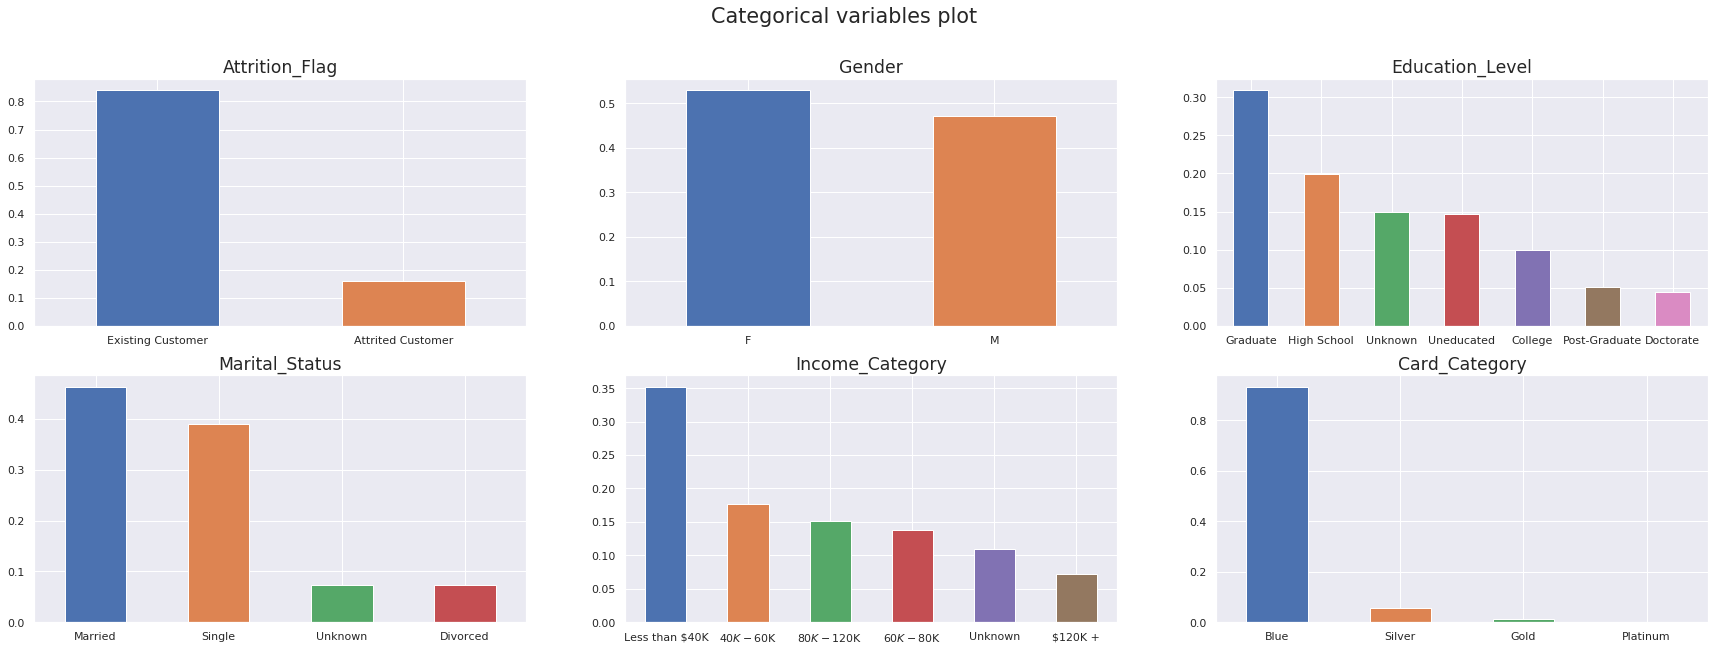

In [104]:
# plot barplots for categorical variables
fig, axes = plt.subplots(2, 3, figsize = (30, 10))
for i, col in enumerate(cat_columns):
    r = i//3
    c = i%3
    df[col].value_counts('normalize').plot.bar(figure = fig, ax = axes[r][c])
    axes[r][c].set_title(col, fontdict = {'fontsize': 'x-large'})
    axes[r][c].tick_params(axis='x', rotation=0)

fig.suptitle('Categorical variables plot', fontsize = 'xx-large')
plt.show()
# To save the plot
# plt.savefig('categorical_variables_plot.png')

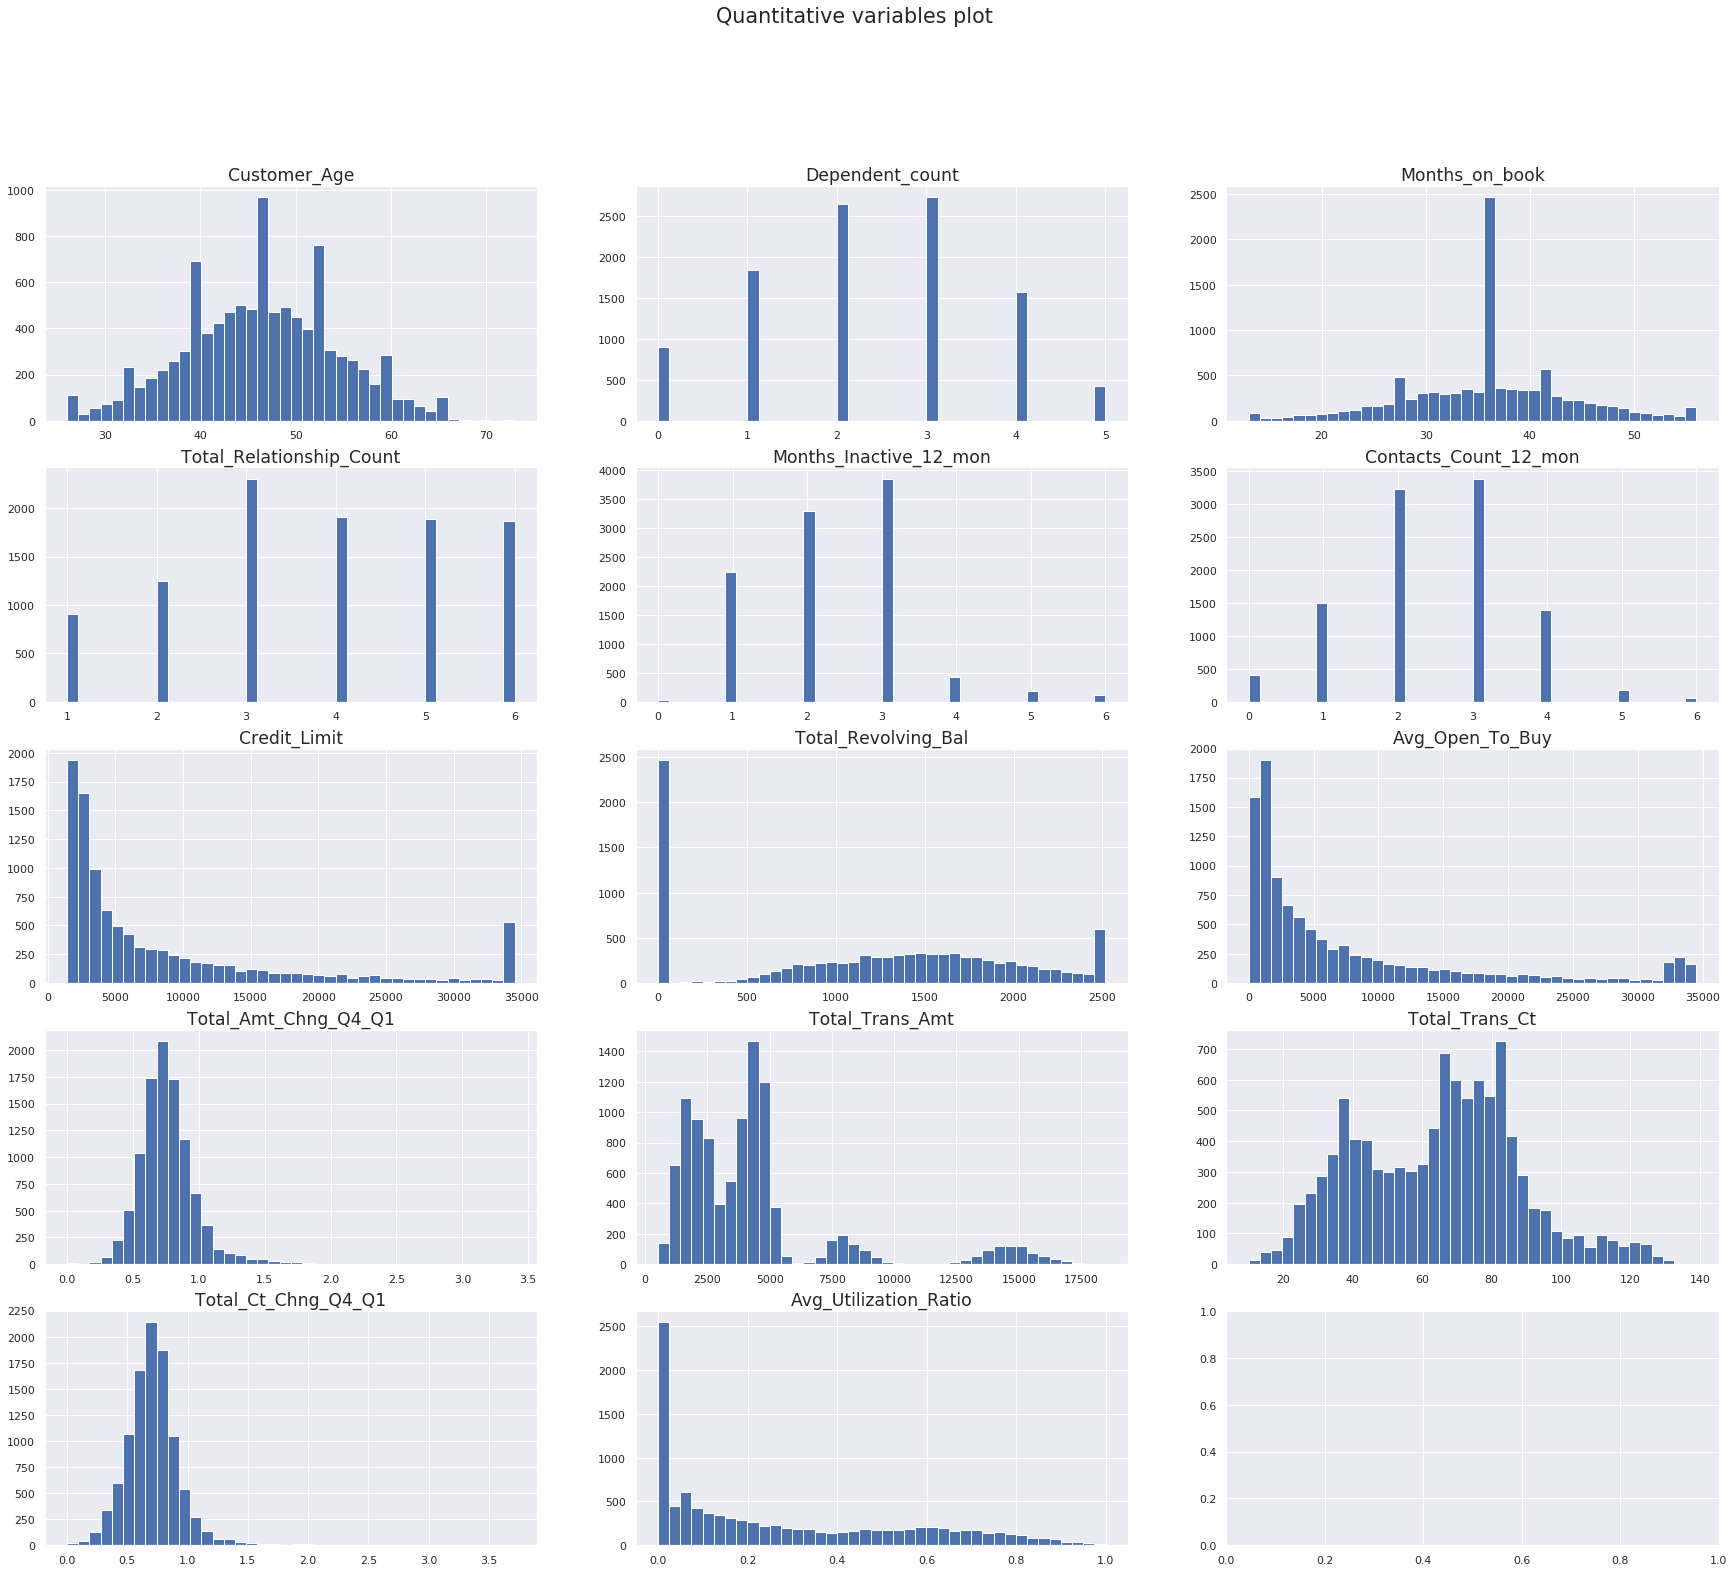

In [105]:
# plot histograms for quantitative variables
fig, axes = plt.subplots(5, 3, figsize = (30, 25))
for i, col in enumerate(quant_columns):
    r = i//3
    c = i%3
    df[col].hist(figure = fig, bins = 40, ax = axes[r][c])
    axes[r][c].set_title(col, fontdict = {'fontsize': 'x-large'})

fig.suptitle('Quantitative variables plot', fontsize = 'xx-large')
plt.show()
# To save the plot
# plt.savefig('quantitative_variables_plot.png')

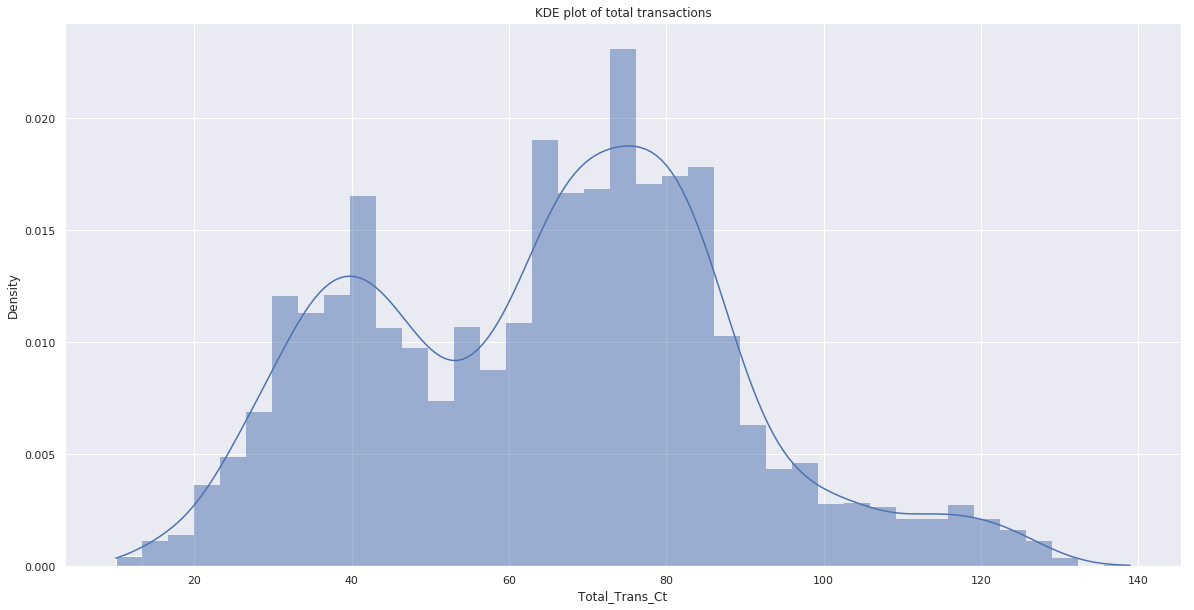

In [106]:
# plot distributions of 'Total_Trans_Ct' and add a smooth curve obtained using a kernel density estimate
plt.figure(figsize=(20,10)) 
plt.title('KDE plot of total transactions')
sns.histplot(df['Total_Trans_Ct'], stat='density', kde=True)
plt.show()
# To save the plot
# plt.savefig('total_transactions_plot.png')

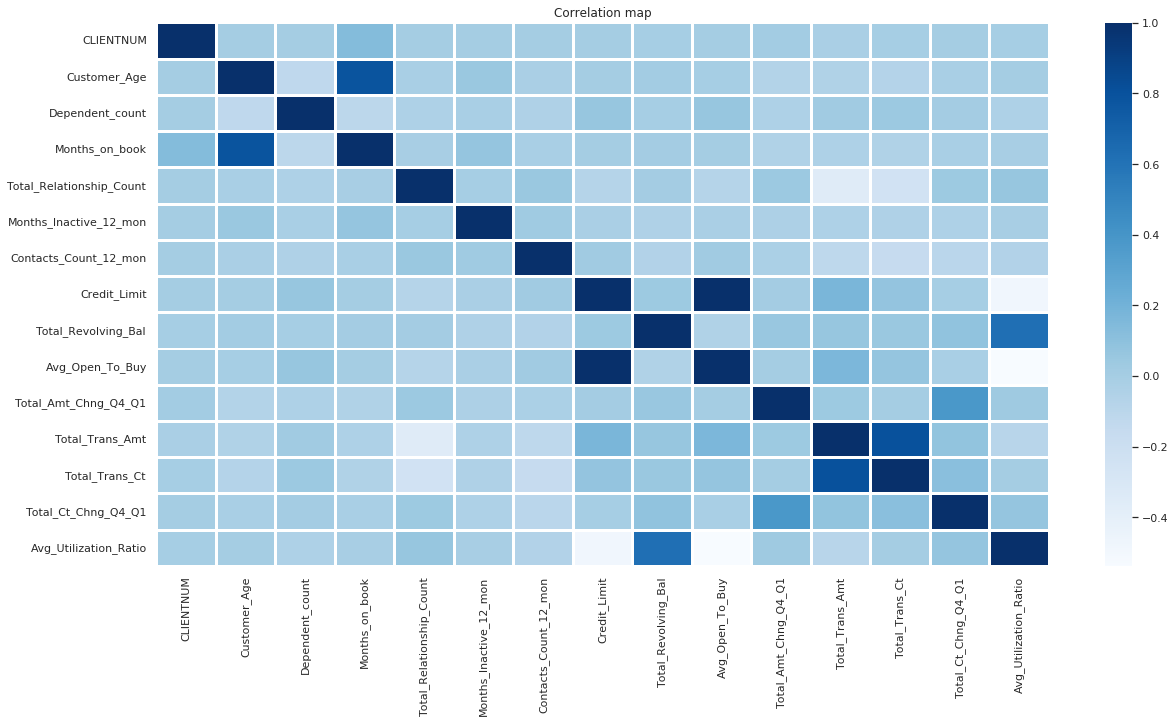

In [107]:
# plot correlation heatmap for all variables 
plt.figure(figsize=(20,10)) 
sns.heatmap(df.corr(), annot=False, cmap='Blues', linewidths = 2)
plt.title('Correlation map')
plt.show()
# To save the plot
# plt.savefig('correlation_map.png')

## ETL

In [108]:
# Transform target column
df['Churn'] = df['Attrition_Flag'].apply(lambda val: 0 if val == "Existing Customer" else 1)

### Choose appropriate encoding method

#### 1) Encoding categorical variables by mean target variable


In [109]:
to_encode_variables = [
    'Gender', 
    'Education_Level', 
    'Marital_Status', 
    'Income_Category', 
    'Card_Category'
]

In [110]:
# encoding categorical variables using mean target variables
mean_encoded_cols = []
for col in to_encode_variables:
    col_lst = []
    col_groups_map = df.groupby(col)['Churn'].mean().to_dict()
    col_name = col + '_Churn'
    df[col_name] = df[col].map(col_groups_map)
    mean_encoded_cols.append(col_name)
    
print(f'Shape of new data: {df.shape}')
print(f'Encoded columns: {mean_encoded_cols}')

Shape of new data: (10127, 27)
Encoded columns: ['Gender_Churn', 'Education_Level_Churn', 'Marital_Status_Churn', 'Income_Category_Churn', 'Card_Category_Churn']


#### 2) Encoding categorical variables by one-hot encoding

In [111]:
# encoding categorical variables using one-hot encoding
one_hot_encoded_cols = []
for col in to_encode_variables:
    tmp_df = pd.get_dummies(df[col], prefix = col, drop_first = True)
    one_hot_encoded_cols.extend(tmp_df.columns)
    df = pd.concat([df, tmp_df], axis = 1)

print(f'Shape of new data: {df.shape}')
print(f'Encoded columns: {one_hot_encoded_cols}')

Shape of new data: (10127, 45)
Encoded columns: ['Gender_M', 'Education_Level_Doctorate', 'Education_Level_Graduate', 'Education_Level_High School', 'Education_Level_Post-Graduate', 'Education_Level_Uneducated', 'Education_Level_Unknown', 'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Unknown', 'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Income_Category_Unknown', 'Card_Category_Gold', 'Card_Category_Platinum', 'Card_Category_Silver']


In [112]:
y = df['Churn']

keep_mean_cols = quant_columns + mean_encoded_cols
keep_ohe_cols = quant_columns + one_hot_encoded_cols

## Model and feature selection

### 1) Model training and prediction with target mean encoded categorical variables

In [113]:
X_mean = pd.DataFrame()
X_mean[keep_mean_cols] = df[keep_mean_cols]
X_mean.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_Churn,Education_Level_Churn,Marital_Status_Churn,Income_Category_Churn,Card_Category_Churn
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.146152,0.152012,0.151269,0.134807,0.160979
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.173572,0.155691,0.169414,0.171862,0.160979
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.146152,0.155691,0.151269,0.157655,0.160979
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.173572,0.152012,0.172230,0.171862,0.160979
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.146152,0.159381,0.151269,0.134807,0.160979


In [19]:
# This cell may take up to 15-20 minutes to run
# train test split 
X_train_mean, X_test_mean, y_train, y_test = train_test_split(X_mean, y, test_size= 0.3, random_state=42)

# grid search
rfc_mean = RandomForestClassifier(random_state=42)
# Use a different solver if the default 'lbfgs' fails to converge
# Reference: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lrc_mean = LogisticRegression(solver='lbfgs', max_iter=3000, verbose = 1)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth'   : [4,5,100],
    'criterion'   : ['gini', 'entropy']
}

cv_rfc_mean = GridSearchCV(
    estimator  = rfc_mean, 
    param_grid = param_grid, 
    cv         = 5, 
    verbose    = 1,
    n_jobs     = -1
)
cv_rfc_mean.fit(X_train_mean, y_train)

lrc_mean.fit(X_train_mean, y_train)

y_train_preds_rf_mean = cv_rfc_mean.best_estimator_.predict(X_train_mean)
y_test_preds_rf_mean = cv_rfc_mean.best_estimator_.predict(X_test_mean)

y_train_preds_lr_mean = lrc_mean.predict(X_train_mean)
y_test_preds_lr_mean = lrc_mean.predict(X_test_mean)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.3min finished
[Parallel(n_jobs=None)]: Done   1 out of   1 | elapsed:    0.2s finished


### 2) Model training and prediction with one-hot encoded categorical variables

In [114]:
X_ohe = pd.DataFrame()
X_ohe[keep_ohe_cols] = df[keep_ohe_cols]
X_ohe.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,...,0,0,0,1,0,0,0,0,0,0
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,...,1,0,0,0,0,1,0,0,0,0
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,...,0,0,0,0,1,0,0,0,0,0
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,...,0,1,0,0,0,1,0,0,0,0
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,...,0,0,0,1,0,0,0,0,0,0


In [21]:
# This cell may take up to 15-20 minutes to run
# train test split 
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X_ohe, y, test_size= 0.3, random_state=42)

# grid search
rfc_ohe = RandomForestClassifier(random_state = 42)
# Use a different solver if the default 'lbfgs' fails to converge
# Reference: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lrc_ohe = LogisticRegression(solver = 'lbfgs', max_iter = 3000, verbose = 1)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth'   : [4,5,100],
    'criterion'   : ['gini', 'entropy']
}

cv_rfc_ohe = GridSearchCV(
    estimator  = rfc_ohe, 
    param_grid = param_grid, 
    cv         = 5, 
    verbose    = 1,
    n_jobs     = -1
)
cv_rfc_ohe.fit(X_train_ohe, y_train)

lrc_ohe.fit(X_train_ohe, y_train)

y_train_preds_rf_ohe = cv_rfc_ohe.best_estimator_.predict(X_train_ohe)
y_test_preds_rf_ohe = cv_rfc_ohe.best_estimator_.predict(X_test_ohe)

y_train_preds_lr_ohe = lrc_ohe.predict(X_train_ohe)
y_test_preds_lr_ohe = lrc_ohe.predict(X_test_ohe)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.5min finished
[Parallel(n_jobs=None)]: Done   1 out of   1 | elapsed:    0.3s finished


### Model and feature selection scores

In [115]:
# scores
print('Random Forest results for mean encoding')
print('Test results')
print(classification_report(y_test, y_test_preds_rf_mean))
print('Train results')
print(classification_report(y_train, y_train_preds_rf_mean))

print('Logistic Regression results for mean encoding')
print('Test results')
print(classification_report(y_test, y_test_preds_lr_mean))
print('Train results')
print(classification_report(y_train, y_train_preds_lr_mean))

print('Random Forest results for one-hot encoding')
print('Test results')
print(classification_report(y_test, y_test_preds_rf_ohe))
print('Train results')
print(classification_report(y_train, y_train_preds_rf_ohe))

print('Logistic Regression results for one-hot encoding')
print('Test results')
print(classification_report(y_test, y_test_preds_lr_ohe))
print('Train results')
print(classification_report(y_train, y_train_preds_lr_ohe))

Random Forest results for mean encoding
Test results
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2543
           1       0.93      0.80      0.86       496

    accuracy                           0.96      3039
   macro avg       0.95      0.90      0.92      3039
weighted avg       0.96      0.96      0.96      3039

Train results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5957
           1       1.00      1.00      1.00      1131

    accuracy                           1.00      7088
   macro avg       1.00      1.00      1.00      7088
weighted avg       1.00      1.00      1.00      7088

Logistic Regression results for mean encoding
Test results
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2543
           1       0.72      0.44      0.54       496

    accuracy                           0.88      3039
  

In [117]:
# selecting best features
X, X_train, X_test = X_mean, X_train_mean, X_test_mean
y_train_preds_rf, y_test_preds_rf = y_train_preds_rf_mean, y_test_preds_rf_mean
y_train_preds_lr, y_test_preds_lr = y_train_preds_lr_mean, y_test_preds_lr_mean
cv_rfc = cv_rfc_mean
lrc = lrc_mean

print(f'Best random forest classifier parameters:\n{cv_rfc.best_params_}')

Best random forest classifier parameters:
{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 200}


## Model evaluation

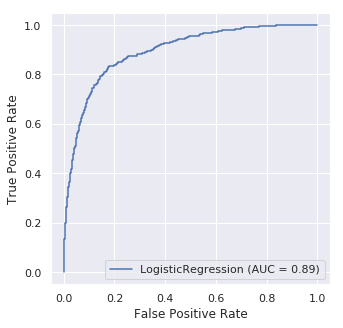

In [118]:
lrc_plot = plot_roc_curve(lrc, X_test, y_test)

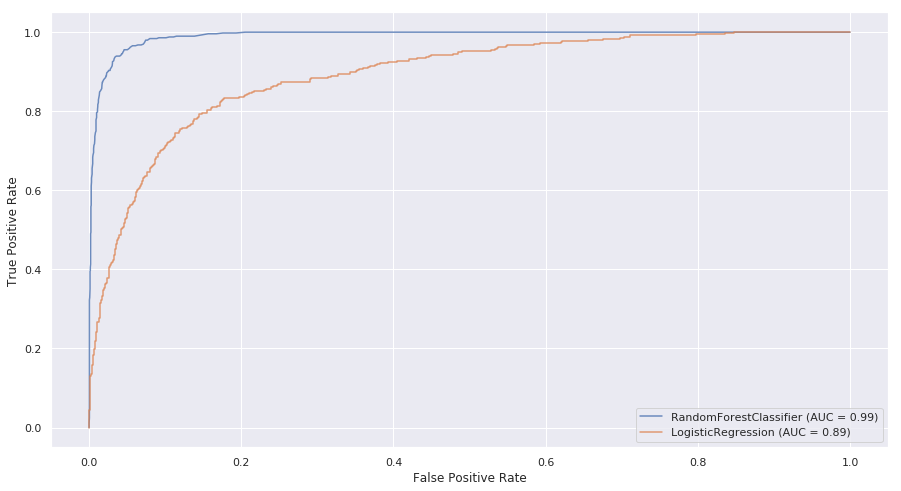

In [119]:
# ROC plots
plt.figure(figsize = (15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(cv_rfc.best_estimator_, X_test, y_test, ax = ax, alpha = 0.8)
lrc_plot.plot(ax = ax, alpha = 0.8)
plt.show()
# To save the plot
# plt.savefig('roc_curve.png')

In [120]:
# save best model
joblib.dump(cv_rfc.best_estimator_, './models/rfc_model.pkl')
joblib.dump(lrc, './models/lrc_model.pkl')

['./models/logistic_model.pkl']

In [121]:
rfc_model = joblib.load('./models/rfc_model.pkl')
lr_model = joblib.load('./models/lrc_model.pkl')

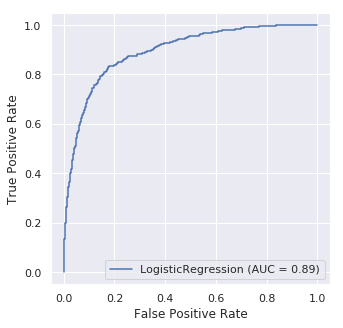

In [122]:
lrc_plot = plot_roc_curve(lr_model, X_test, y_test)

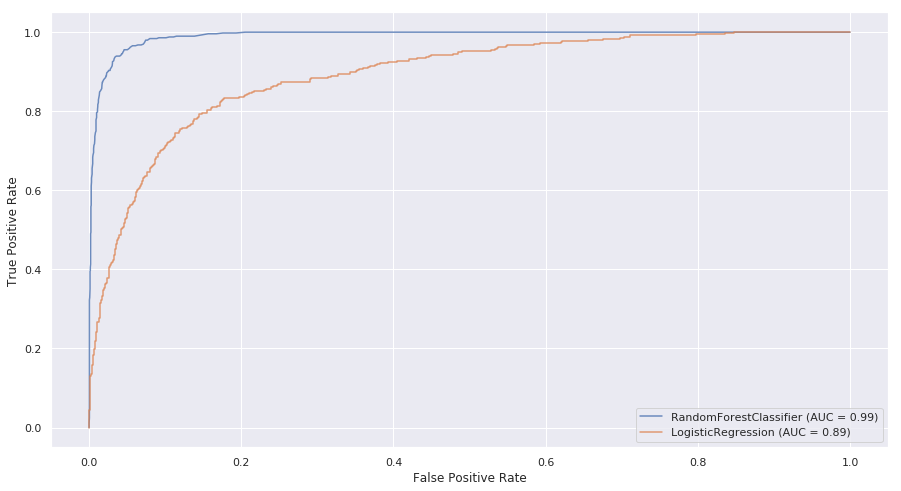

In [123]:
# ROC plots
plt.figure(figsize = (15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc_model, X_test, y_test, ax = ax, alpha = 0.8)
lrc_plot.plot(ax = ax, alpha = 0.8)
plt.show()
# To save the plot
# plt.savefig('roc_curve.png')

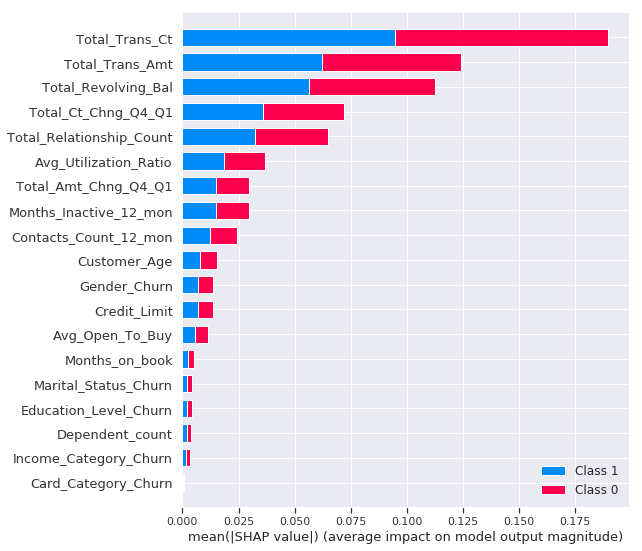

In [124]:
explainer = shap.TreeExplainer(cv_rfc.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type = "bar")
# To save the plot
# shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
# plt.savefig('featture_impacts.png')

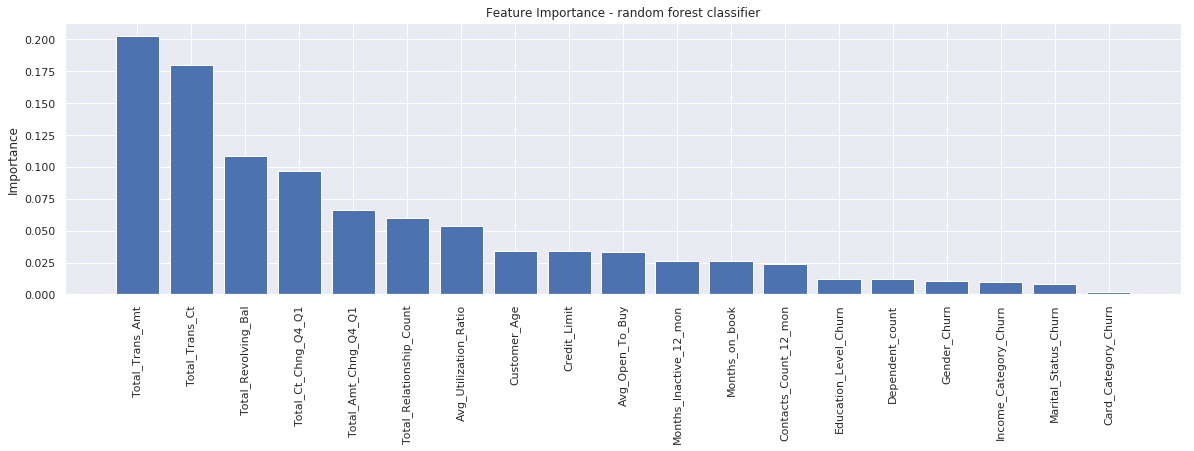

In [125]:
# Calculate feature importances for random forest classifier
importances = cv_rfc.best_estimator_.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize = (20, 5))

# Create plot title
plt.title("Feature Importance - random forest classifier")
plt.ylabel('Importance')

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation = 90)
plt.show()
# To save the plot
# plt.savefig('feature_importance.png')

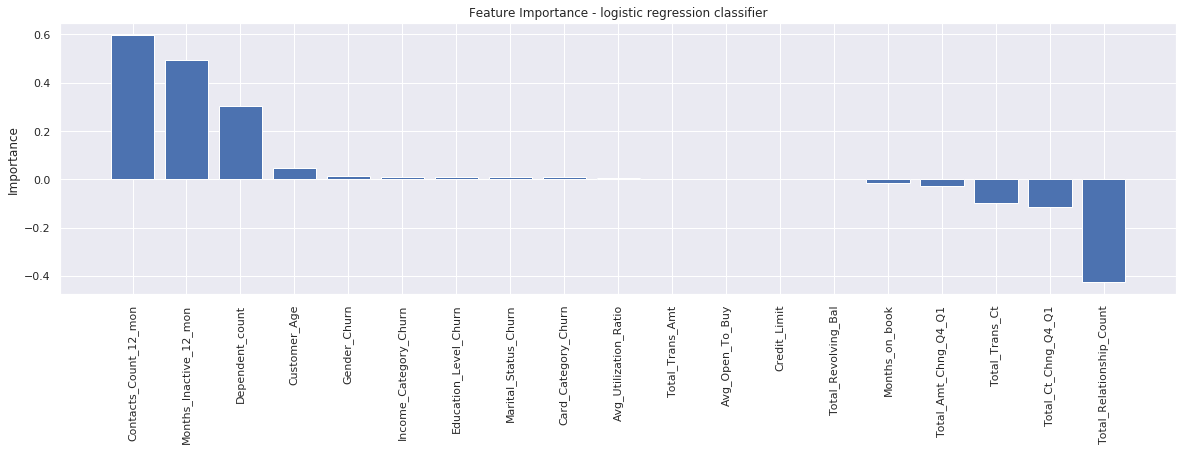

In [126]:
# Calculate feature importances for logistic regression classifier
importances = lr_model.coef_[0]
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize = (20, 5))

# Create plot title
plt.title("Feature Importance - logistic regression classifier")
plt.ylabel('Importance')

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation = 90)
plt.show()
# To save the plot
# plt.savefig('feature_importance.png')

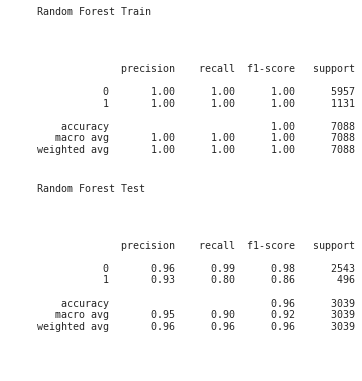

In [32]:
plt.rc('figure', figsize=(5, 5))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 1.25, str('Random Forest Train'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.05, str(classification_report(y_test, y_test_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.6, str('Random Forest Test'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_train, y_train_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.show()
# To save the plot
# plt.savefig('random_forest_scores.png')

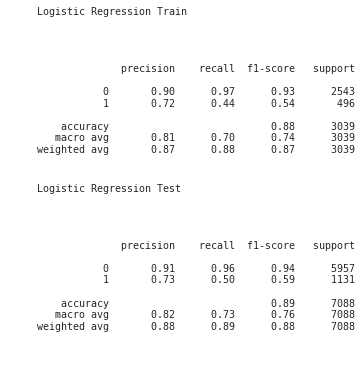

In [33]:
plt.rc('figure', figsize=(5, 5))
plt.text(0.01, 1.25, str('Logistic Regression Train'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.05, str(classification_report(y_train, y_train_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.6, str('Logistic Regression Test'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_test, y_test_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.show()
# To save the plot
# plt.savefig('logistic_regression_scores.png')